In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from utils.camera import *
from utils.read_matches import *
from utils.misc import *
from utils.plotting import *
from utils.non_parametric import *
from utils.read_write_model import *

import pyimplicitdist
import poselib
import matplotlib.pyplot as plt
import scipy.io
import PIL
from itertools import compress
# from calib_experiment import *

## Undistorting Catadioptric Images

(2848, 4288, 3)
[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17]]
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
[[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
focal = 2144.0000000000005
[[ 6.12323400e-17 -6.12323400e-17  1.00000000e+00]
 [ 1.00000000e+00  3.74939946e-33 -6.12323400e-17]
 [ 0.00000000e+00  1.00000000e+00  6.12323400e-17]]
focal = 2144.0000000000005
[[-1.00000000e+00 -7.49879891e-33  1.22464680e-16]
 [ 1.22464680e-16 -6.12323400e-17  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  6.12323400e-17]]
focal = 2144.0000000000005
[[-1.83697020e-16  6.12323400e-17 -1.00000000e+00]
 [-1.00000000e+00 -1.12481984e-32  1.83697020e-16]
 [ 0.00000000e+00  1.00000000e+00  6.12323400e-17]]
focal = 2144.0000000000005
[[ 1.0

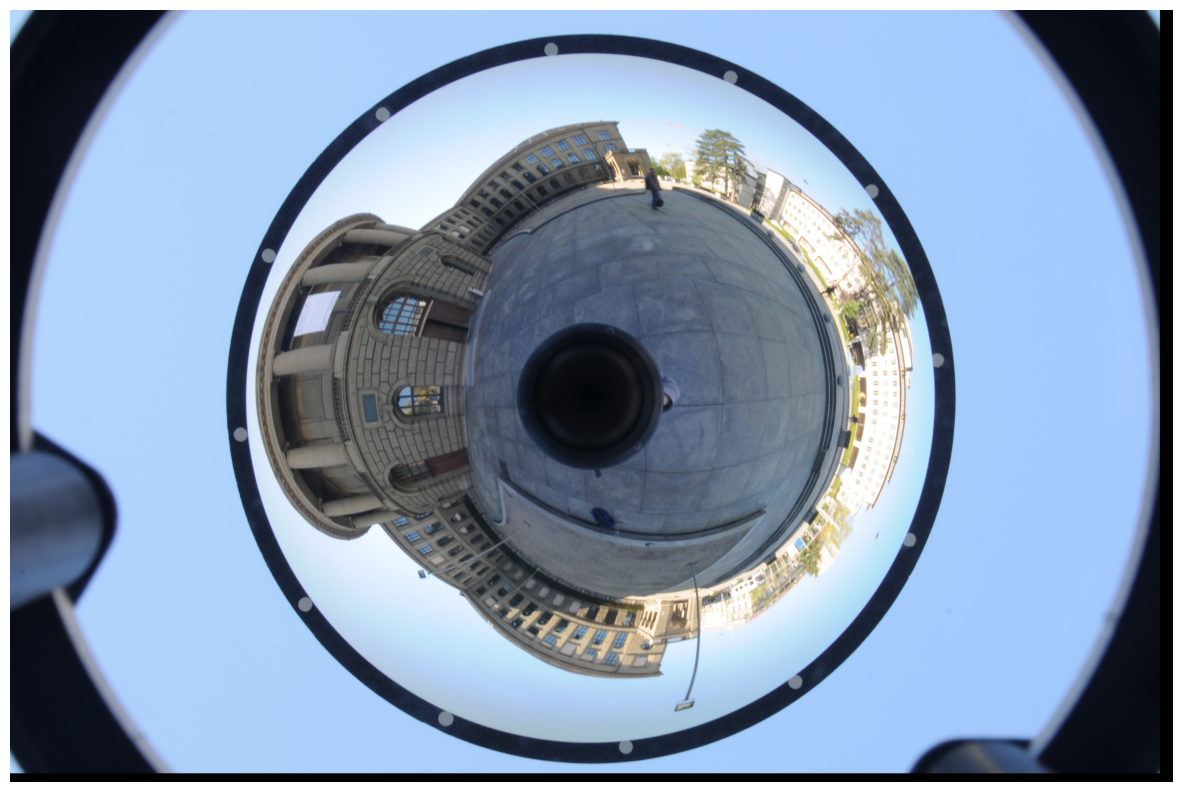

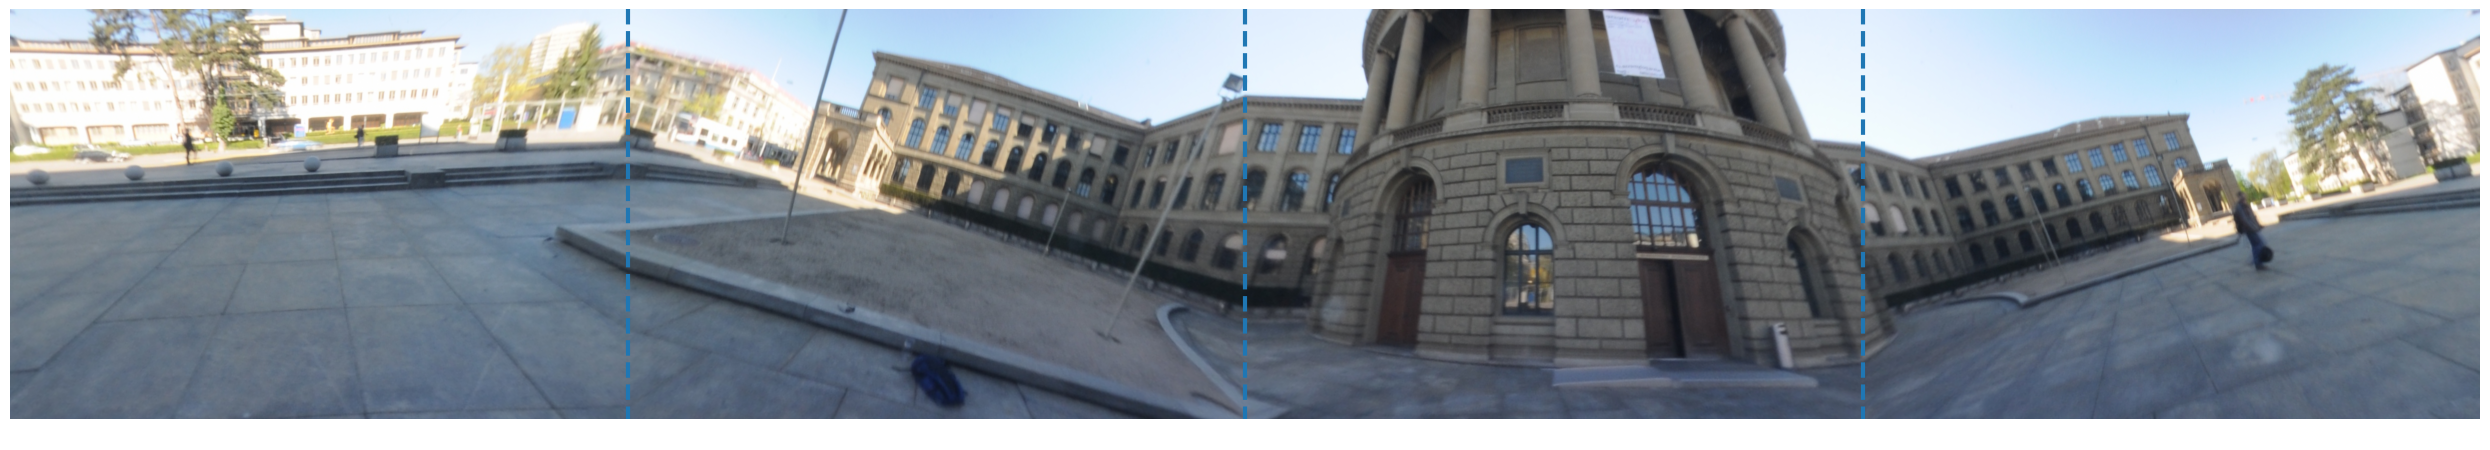

In [6]:
# Catadioptric cameras
# Undistort test image
im_file = './test_data/DSC_1276.JPG'
image = PIL.Image.open(im_file)
im_test = np.array(image)
intrinsics = pyimplicitdist.IntrinsicCalib()

calib_path = './test_data/dsc_1320.txt'
r_f = []
theta_r = []
with open(calib_path, 'r') as f:
    for line in f:
        data = line.split()
        if data[0] == '#':
                continue 
        theta_r.append((float(data[0]), float(data[1])))
        r_f.append((float(data[1]), float(data[1])/np.tan(float(data[0]))))
intrinsics.theta_r = theta_r
intrinsics.r_f = r_f
intrinsics.pp = np.array([2188.46, 1388.89])

plt.figure(figsize=(15,15))
plt.imshow(im_test)

plt.axis('off')
rr,ff = zip(*intrinsics.r_f)
rr = np.array(rr)
ff = np.array(ff)

print(im_test.shape)

theta = np.deg2rad(90)
ct = np.cos(theta)
st = np.sin(theta)
rotation_x = np.array([[1,0,0], [0,ct,-st], [0,st,ct]])
rotation_y = np.array([[ct,0,-st], [0,1,0], [st,0,ct]])
rotation_z = np.array([[ct,-st,0], [st,ct,0], [0,0,1]])

print(rotation_x)
print(rotation_y)
print(rotation_z)

width = image.size[0]
height = image.size[1]

im_all = np.zeros((height,0,3),dtype=np.uint8)

rotation = rotation_x
for i in range(4):
    rotation =  rotation_z @ rotation 
    #rotation = rotation @ rotation_z
    
    im_undist = undistort_image(im_test, intrinsics, width, height, hfov=90, rotation=rotation )
    im_undist = np.squeeze(im_undist)
    im_undist = (im_undist*255.0).astype(np.uint8)

    im_all = np.concatenate((im_all,im_undist),axis=1)
    print(rotation)
    
plt.figure(figsize=(25,25))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']   
plt.imshow(im_all)
for k in [1,2,3]:
    plt.plot([k*width, k*width],[0,height],'--',color=colors[0],linewidth=3)
plt.axis('off')

plt.tight_layout()


## Undistort Fisheye Images

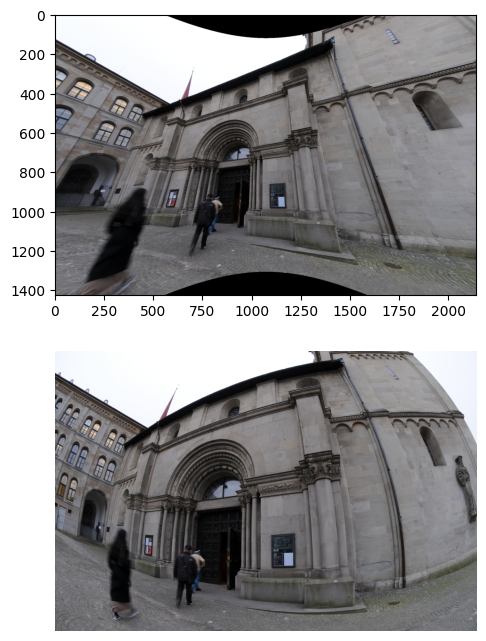

In [10]:
im = plt.imread('./test_data/DSC_2946.JPG')
im_height, im_width,_  = im.shape

# read intrisics
intrinsics = pyimplicitdist.IntrinsicCalib()

calib_path = './test_data/fisheye.txt'
r_f = []
theta_r = []
with open(calib_path, 'r') as f:
    for line in f:
        for line in f:
            data = line.split()
            if data[0] == '#':
                continue                
            theta_r.append((float(data[0]), float(data[1])))
            r_f.append((float(data[1]), float(data[1])/np.tan(float(data[0]))))

intrinsics.theta_r = theta_r
intrinsics.r_f = r_f
intrinsics.pp = np.array([im_width/2, im_height/2])

target_fov = 120 / 180 * np.pi
subsample = 2
target_h = int(np.ceil(im_height / subsample))
target_w = int(np.ceil(im_width / subsample))

target_focal = target_w / 2 / np.tan(target_fov/2)

ii, jj = np.meshgrid(np.linspace(1,target_w,target_w), np.linspace(1,target_h,target_h), indexing='ij')
ii = ii - 0.5
jj = jj - 0.5

# Remove principal point
ii = ii - target_w / 2
jj = jj - target_h / 2


X = np.c_[ ii.flatten(), jj.flatten(), target_focal * np.ones(np.prod(ii.shape)) ]
x = np.array(pyimplicitdist.distort(X, intrinsics))
im_undist = np.zeros((target_h, target_w, 3), dtype=im.dtype)
for i in range(target_w):
    for j in range(target_h):
        coord = x[j + i*target_h]
        if np.any(coord < 0) or coord[1] > im_height-1 or coord[0] > im_width-1:
            continue          
        if np.any(np.isnan(coord)):
            continue
        im_undist[j,i] = im[int(coord[1]), int(coord[0])]
        

fig = plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.imshow(im_undist)
plt.subplot(2,1,2)
# turn off axis
plt.axis('off')
plt.imshow(im)